In [ ]:
# to do: 
# 
# signed sum using iter_tools package on Python to find the number of combinations for 5 qubits of [+1, -1]: +1+1-1-1-1
# This becomes a classification task where +1 is positive and -1 is negative: this is a signed sum

import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator
from itertools import product

CIRCUIT_DEPTH = 7
QUBITS = 5 
CENTER = int(QUBITS/2)
# gates used is CIRCUIT_DEPTH*2 + 1
# c (central qubit) and l (maximum number of qubits), run 2 loops and iterate to connect to the central qubit

def QSP(circuit, params, theta):
    for i in range(CIRCUIT_DEPTH):
        for q in range(QUBITS):
            circuit.rz(params[i], q)
            circuit.rx(theta[q], q)
    for q in range(5):       
        circuit.rz(params[CIRCUIT_DEPTH], q)
    return circuit

def entangle(circuit):
    middle = 2
    for i in range(CENTER+1):
        if(i != 0):
            # die
            # continue # skip itself
            circuit.cx(CENTER, CENTER+i) 
            circuit.cx(CENTER, CENTER-i) 

    return circuit


# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    circuit = QuantumCircuit(QUBITS)
    circuit = QSP(circuit, params, theta)
    circuit = entangle(circuit)
    return circuit


# Function to compute the expectation value <0|U|0> --> |00000>U<00000|
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)
    
    # Projector onto the |00000⟩ state
    projector = np.zeros((2**5, 2**5))
    projector[0,0] = 1 # |00000><00000|
    
    # Compute the expectation value
    expectation = state.expectation_value(Operator(projector))
    return np.real(expectation)

def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):

        exp_val = expectation_value(params, x)

        # y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        y_pred = exp_val  # Each alpha corresponds to a specific theta (x)

        prediction = 0
        if y_pred > 0:
            prediction = 1
        else:
            prediction = -1
        if prediction != y_true:
            error += 1

    return error / len(x_values)

In [ ]:
X = np.array(list(product([-1, 1], repeat=5)))
Y = []
for i in X:
    if sum(i) < 0:
        Y.append(-1)
    else:
        Y.append(1)
Y = np.array(Y)

np.random.seed(11)

shuffle = np.random.permutation(len(X))

TRAINING_SET_SIZE = 32
training_indices  = shuffle[:TRAINING_SET_SIZE]
test_indices = shuffle[TRAINING_SET_SIZE:]

x_train = [X[i] for i in training_indices]
y_train = [Y[i] for i in training_indices]
x_test = [X[i] for i in test_indices]
y_test = [Y[i] for i in test_indices]

# Initialize random guesses for parameters, alphas, and phases
param_count = CIRCUIT_DEPTH + 1 
init_params = np.random.uniform(0, 2 * np.pi, param_count)
init_alphas = np.random.uniform(-1, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:param_count]
    alphas = params_and_alphas_phases[param_count:param_count+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:param_count]
optimal_alphas = result.x[param_count:param_count+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]


# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)


Optimal parameters: [4.88896657 0.15801756 5.78856502 2.58183799 1.19193726 1.28182872
 5.4286987  0.97480405]
Optimal alphas: [ 0.54966123 -0.03378753  0.56661842 -0.91019035  0.24256432 -0.11505501
  0.79532615 -0.86181439  0.01285078 -0.07018797  0.35781417 -0.02968236
 -0.14569563 -0.20354184 -0.91399294 -0.6076245  -0.04709367 -0.92611454
 -0.98800064  0.84769971  0.35506159  0.97651359 -0.06071841  0.64707228
 -0.89863923  0.48781173 -0.4735258   0.95427323  0.33097604  0.98780361
 -0.35979438  0.57803394]
Predictions: [0.06423404611226827, -0.003948450117724697, 0.06621568313934306, -0.10636589613193007, 0.028346346461386653, -0.013445461846028316, 0.09294273298704955, -0.10071262481036351, 0.0015017564775024158, -0.008202247399176053, 0.04181457704185957, -0.0034687154023208735, -0.01702615961121035, -0.02378613504937273, -0.10681027039459716, -0.07100770102831114, -0.005503420656129249, -0.10822681542463491, -0.11545889641148674, 0.09906316784052661, 0.04149290750976259, 0.114

Training Accuracy: 59.38%


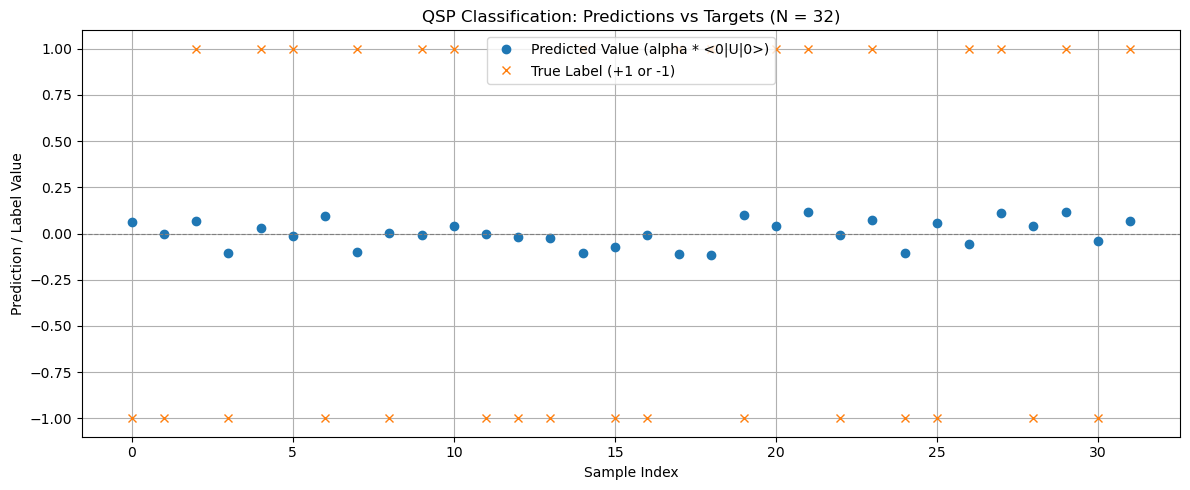

In [ ]:
import matplotlib.pyplot as plt

# Classify predictions to +1 or -1
classified_preds = [1 if p > 0 else -1 for p in predictions]

# Accuracy
correct = sum(p == y for p, y in zip(classified_preds, y_train))
accuracy = correct / len(y_train)
print(f"Training Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(12, 5))
plt.plot(predictions, 'o', label='Predicted Value (alpha * <0|U|0>)')
plt.plot(y_train, 'x', label='True Label (+1 or -1)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title(f'QSP Classification: Predictions vs Targets (N = {TRAINING_SET_SIZE})')
plt.xlabel('Sample Index')
plt.ylabel('Prediction / Label Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# from itertools import product

# # All 32 binary input combinations (5 spins)
# full_X = np.array(list(product([-1, 1], repeat=5)))
# full_Y = np.array([1 if sum(x) >= 0 else -1 for x in full_X])

# # Get predictions for the full dataset using trained weights
# full_predictions = [alpha * expectation_value(optimal_params, x)
#                     for x, alpha in zip(full_X, optimal_alphas[:len(full_X)])]

# # Apply sign threshold
# classified_full_preds = [1 if p > 0 else -1 for p in full_predictions]

# # Check accuracy
# correct = sum([yp == yt for yp, yt in zip(classified_full_preds, full_Y)])
# accuracy = correct / len(full_X)
# print(f"Full Dataset Accuracy (Memorization Check): {accuracy * 100:.2f}%")

# # Optionally, show mismatches
# for i, (inp, yp, yt) in enumerate(zip(full_X, classified_full_preds, full_Y)):
#     if yp != yt:
#         print(f"Mismatch #{i}: Input={inp}, Pred={yp}, True={yt}")


Full Dataset Accuracy (Memorization Check): 46.88%
Mismatch #1: Input=[-1 -1 -1 -1  1], Pred=1, True=-1
Mismatch #2: Input=[-1 -1 -1  1 -1], Pred=1, True=-1
Mismatch #5: Input=[-1 -1  1 -1  1], Pred=1, True=-1
Mismatch #6: Input=[-1 -1  1  1 -1], Pred=1, True=-1
Mismatch #7: Input=[-1 -1  1  1  1], Pred=-1, True=1
Mismatch #8: Input=[-1  1 -1 -1 -1], Pred=1, True=-1
Mismatch #9: Input=[-1  1 -1 -1  1], Pred=1, True=-1
Mismatch #10: Input=[-1  1 -1  1 -1], Pred=1, True=-1
Mismatch #11: Input=[-1  1 -1  1  1], Pred=-1, True=1
Mismatch #14: Input=[-1  1  1  1 -1], Pred=-1, True=1
Mismatch #15: Input=[-1  1  1  1  1], Pred=-1, True=1
Mismatch #17: Input=[ 1 -1 -1 -1  1], Pred=1, True=-1
Mismatch #19: Input=[ 1 -1 -1  1  1], Pred=-1, True=1
Mismatch #21: Input=[ 1 -1  1 -1  1], Pred=-1, True=1
Mismatch #26: Input=[ 1  1 -1  1 -1], Pred=-1, True=1
Mismatch #28: Input=[ 1  1  1 -1 -1], Pred=-1, True=1
Mismatch #29: Input=[ 1  1  1 -1  1], Pred=-1, True=1
